<br/>

$$ \huge{\underline{\textbf{ Episodic Semi-Gradient Sarsa }}} $$

<br/>

<img src="assets/1001_Ep_Semi_Grad_Sarsa.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 10.1 </center>

<br/>

In [3]:
def ep_semi_grad_sarsa(env, ep, gamma, eps, q_hat, callback=None, trace=None):
    """Episodic Semi-Gradient Sarsa
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        q_hat      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
    """
    def policy(st, q_hat, eps):
        if np.random.rand() > eps:
            q_values = [q_hat.eval(st,a) for a in env.act_space]
            return argmax_rand(q_values)
        else:
            return np.random.choice(env.act_space)
    
    for e_ in range(ep):
        S = env.reset()
        A = policy(S, q_hat, eps)
        for t_ in range(10**100):       
            S_, R, done = env.step(A)
            if done:
                q_hat.train(S, A, R)
                break
            A_ = policy(S_, q_hat, eps)
            target = R + gamma * q_hat.eval(S_, A_)
            q_hat.train(S, A, target)
            S, A = S_, A_
                
            if callback is not None:
                callback(e_, t_, q_hat, trace)
                

Tile Coding - see [chapter 9.5](0905b_LM_Agg_Tile.ipynb) for introduction

In [33]:
class TileCodingFuncApprox():
    def __init__(self, st_low, st_high, nb_actions, learn_rate, num_tilings, init_val):
        """
        Params:
            st_low      - state space low boundry in all dim, e.g. [-1.2, -0.07] for mountain car
            st_high     - state space high boundry in all dimensions
            nb_actions  - number of possible actions
            learn_rate  - step size, will be adjusted for nb_tilings automatically
            num_tilings - tiling layers - should be power of 2 and at least 4*len(st_low)
            init_val    - initial state-action values
        """
        assert len(st_low) == len(st_high)
        self._n_dim = len(st_low)
        self._lr = learn_rate / num_tilings
        self._num_tilings = num_tilings
        self._scales = self._num_tilings / (st_high - st_low)
        
        # e.g. 8 tilings, 2d space, 3 actions
        # nb_total_tiles = (8+1) * (8+1) * 8 * 3
        nb_total_tiles = (num_tilings+1)**self._n_dim * num_tilings * nb_actions
                
        self._iht = tiles3.IHT(nb_total_tiles)
        self._weights = np.zeros(nb_total_tiles) + init_val / num_tilings
        
    def eval(self, state, action):
        assert len(state) == self._state_dim
        assert np.isscalar(action)
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles3.tiles(                     # find active tiles
            self._iht, self._num_tilings,
            scaled_state, [action])
        return np.sum(self._weights[active_tiles])       # pick correct weights and sum up

    def train(self, state, action, target):
        assert len(state) == self._state_dim
        assert np.isscalar(action)
        assert np.isscalar(target)
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles3.tiles(                     # find active tiles
            self._iht, self._num_tilings,
            scaled_state, [action])
        value = np.sum(self._weights[active_tiles])      # q-value for state-action pair
        delta = self._lr * (target - value)              # grad is [0,1,0,0,..]
        self._weights[active_tiles] += delta             # ..so we pick active weights instead

Helper functions

In [2]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

# Solve Mountain Car

Imports (source file: [tiles3.py](tiles3.py))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mountain_car import MountainCarEnv
import tiles3           # by Richard Sutton, http://incompleteideas.net/tiles/tiles3.html

Environment

In [22]:
env = MountainCarEnv()

In [23]:
q_hat = TileCodingFuncApprox(env.state_low, env.state_high, len(env.act_space),
                             learn_rate=0.3, num_tilings=8, init_val=0)

In [24]:
ep_semi_grad_sarsa(env, ep=500, gamma=1.0, eps=0.1, q_hat=q_hat)

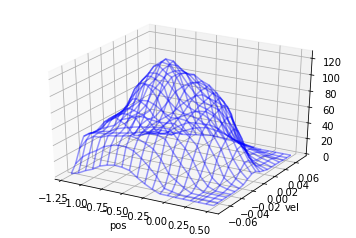

In [30]:
plot_Q_model(q_hat)

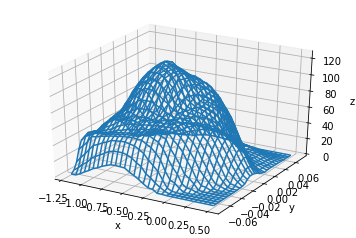

In [93]:
plot_2d_q_max(q_hat, env, inv=True)

In [91]:
def plot_2d_q_max(q_hat, env, inv=False, split=[32,32], color='#1f77b4',
                  alpha=1., labels=['x','y','z'], axis=None):
    """Plot 2D wireframe
    
    Params:
        q_hat     - function approximator with method: q_hat.eval(state, action) -> float
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
                      act_space - action space, e.g. [0, 1, 2]
        inv       - inverse q-values? (mult by -1)
        split     - number of data points in each dimensions, e.g. [20, 20]
        color     - plot color
        alpha     - plot transparency
        labels    - string array [label_x, label_y, label_z], len=3, empty str to omit
        axis      - axis to plot to, if None create new figure
    """
    q_arr = q_hat_to_array(q_hat, env, split)
    q_max = np.max(q_arr, axis=-1)
    if inv:
        q_max *= -1
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111, projection='3d')

    # [-1.2, 0.5, -0.07, 0.07]
    extent = [env.state_low[0], env.state_high[0], env.state_low[1], env.state_high[1]]
    plot_q_val_wireframe(axis, q_max, extent=extent,
                         labels=labels, color=color, alpha=alpha)

In [80]:
def q_hat_to_array(q_hat, env, split=[32,32]):
    """Evaluate 2d Q-function on area and return as 3d array
    
    Params:
        q_hat     - function approximator with method: q_hat.eval(state, action) -> float
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
                      act_space - action space, e.g. [0, 1, 2]
        split     - number of data points in each dimensions, e.g. [20, 20]
    """
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    x_split, y_split = split
    
    q_arr = np.zeros([x_split, y_split, len(env.act_space)])

    for pi, pos in enumerate(np.linspace(x_min, x_max, x_split)):
        for vi, vel in enumerate(np.linspace(y_min, y_max, y_split)):
            for act in env.act_space:
                q_arr[pi, vi, act] = q_hat.eval(state=[pos, vel], action=act)
                
    return q_arr

In [81]:
def plot_q_val_wireframe(ax, q_val, extent, labels, color='#1f77b4', alpha=1.):
    """Plot 2d q_val array on 3d wireframe plot.
    
    Params:
        ax: axis to plot on
        q_val: 2d numpy array as follows:
               1-st dim is X, increasing as indices grow
               2-nd dim is Y, increasing as indices grow
        extent: [x_min, x_max, y_min, y_max]
        labels: [x_label, y_label, z_label]
    """

    assert len(extent) == 4
    assert len(labels) == 3

    x_min, x_max, y_min, y_max = extent
    x_label, y_label, z_label = labels

    x_size = q_val.shape[0]
    y_size = q_val.shape[1]
    x_space = np.linspace(x_min, x_max, x_size)
    y_space = np.linspace(y_min, y_max, y_size)

    Y, X = np.meshgrid(y_space, x_space)
    
    ax.plot_wireframe(X, Y, q_val, color=color, alpha=alpha)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)